# 🚀 Thai Text Classification with Transformer
### Encoder: XLM-RoBERTa (BERT) | Decoder: Transformer
---
**Settings:** (Memory Optimized)
- Train/Test/Valid = 80/10/10
- MAX_LEN = 256
- BATCH_SIZE = 16 (with gradient accumulation = 8 → effective batch = 128)
- EPOCHS = 500
- dim = 300, depth = 4, heads = 4
- LR = 2e-4, threshold = 0.5

**Memory Optimizations:**
- Gradient Accumulation
- Freeze BERT (optional)
- Mixed Precision Training

In [1]:
# 📦 Install dependencies
!pip install -q transformers scikit-learn pandas x-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00


In [2]:
# 📚 Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from x_transformers import Decoder
import time
import os
import gc
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# ⚙️ SETTINGS - Memory Optimized
MAX_LEN = 256
BATCH_SIZE = 16           # ลดจาก 128 เป็น 16 เพื่อประหยัด memory
GRADIENT_ACCUMULATION = 8  # สะสม gradient 8 steps = effective batch 128
EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRADIENT_ACCUMULATION  # = 128

EPOCHS = 100
LEARNING_RATE = 2e-4
DECODER_DIM = 300  # dim=300
DEPTH = 4
HEADS = 4
THRESHOLD = 0.5

# Split ratios
TRAIN_RATIO = 0.80
TEST_RATIO = 0.10
VALID_RATIO = 0.10

# BERT Model
BERT_MODEL = "xlm-roberta-base"
BERT_HIDDEN_SIZE = 768
FREEZE_BERT = True  # 🔒 Freeze BERT เพื่อประหยัด memory มาก!

CHECKPOINT_EVERY = 10

print("✅ Settings loaded (Memory Optimized):")
print(f"   BERT_MODEL = {BERT_MODEL}")
print(f"   FREEZE_BERT = {FREEZE_BERT} (saves ~60% GPU memory)")
print(f"   MAX_LEN = {MAX_LEN}")
print(f"   BATCH_SIZE = {BATCH_SIZE} (actual)")
print(f"   GRADIENT_ACCUMULATION = {GRADIENT_ACCUMULATION}")
print(f"   EFFECTIVE_BATCH_SIZE = {EFFECTIVE_BATCH_SIZE}")
print(f"   EPOCHS = {EPOCHS}")
print(f"   LEARNING_RATE = {LEARNING_RATE}")
print(f"   DECODER_DIM = {DECODER_DIM}")
print(f"   DEPTH = {DEPTH}")
print(f"   HEADS = {HEADS}")
print(f"   THRESHOLD = {THRESHOLD}")
print(f"   Train/Valid/Test = {TRAIN_RATIO*100:.0f}%/{VALID_RATIO*100:.0f}%/{TEST_RATIO*100:.0f}%")

✅ Settings loaded (Memory Optimized):
   BERT_MODEL = xlm-roberta-base
   FREEZE_BERT = True (saves ~60% GPU memory)
   MAX_LEN = 256
   BATCH_SIZE = 16 (actual)
   GRADIENT_ACCUMULATION = 8
   EFFECTIVE_BATCH_SIZE = 128
   EPOCHS = 4
   LEARNING_RATE = 0.0002
   DECODER_DIM = 300
   DEPTH = 4
   HEADS = 4
   THRESHOLD = 0.5
   Train/Valid/Test = 80%/10%/10%


In [4]:
# 🔧 Check GPU and clear cache
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🟢 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()
    gc.collect()
    print("✅ GPU cache cleared!")

🟢 Using device: cuda
GPU: Tesla P100-PCIE-16GB
VRAM: 17.1 GB
✅ GPU cache cleared!


In [5]:
# 📂 Load all three datasets and combine them
print("📂 Loading datasets...")

# Kaggle paths
possible_paths = [
    "/kaggle/input/prachatai-dataset/",
    "/kaggle/input/",
    "./"
]

data_path = None
for path in possible_paths:
    if os.path.exists(os.path.join(path, "prachatai_train.csv")):
        data_path = path
        print(f"Found data at: {path}")
        break

if data_path is None:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if 'train' in filename.lower() and filename.endswith('.csv'):
                data_path = dirname + '/'
                print(f"Found data at: {data_path}")
                break
        if data_path:
            break

# Load all three datasets
df_train = pd.read_csv(os.path.join(data_path, "prachatai_train.csv"))
df_val = pd.read_csv(os.path.join(data_path, "prachatai_validation.csv"))
df_test = pd.read_csv(os.path.join(data_path, "prachatai_test.csv"))

# Combine all datasets
df = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(f"\n✅ Combined dataset size: {len(df)}")

texts = df["body_text"].astype(str).tolist()
label_cols = [
    "politics", "human_rights", "quality_of_life", "international",
    "social", "environment", "economics", "culture", "labor",
    "national_security", "ict", "education"
]
y = df[label_cols].values.astype(np.float32)

# Free memory
del df_train, df_val, df_test, df
gc.collect()

print(f"📋 Labels: {label_cols}")
print(f"📋 Number of labels: {len(label_cols)}")

📂 Loading datasets...
Found data at: /kaggle/input/prachatai-dataset/

✅ Combined dataset size: 67889
📋 Labels: ['politics', 'human_rights', 'quality_of_life', 'international', 'social', 'environment', 'economics', 'culture', 'labor', 'national_security', 'ict', 'education']
📋 Number of labels: 12


In [6]:
# 🔤 Load BERT Tokenizer and Model
print(f"\n🔤 Loading {BERT_MODEL}...")

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
bert_encoder = AutoModel.from_pretrained(BERT_MODEL)

# 🔒 Freeze BERT to save memory
if FREEZE_BERT:
    for param in bert_encoder.parameters():
        param.requires_grad = False
    print("🔒 BERT weights FROZEN (saves ~60% GPU memory)")

print(f"✅ Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"✅ BERT hidden size: {bert_encoder.config.hidden_size}")
BERT_HIDDEN_SIZE = bert_encoder.config.hidden_size


🔤 Loading xlm-roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2026-01-26 17:00:16.644750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769446816.832711      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769446816.884628      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769446817.335480      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769446817.335511      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769446817.335513      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

🔒 BERT weights FROZEN (saves ~60% GPU memory)
✅ Tokenizer vocab size: 250002
✅ BERT hidden size: 768


In [7]:
# 📊 Train/Valid/Test Split (80/10/10)
print(f"\n📊 Splitting data: Train={TRAIN_RATIO*100:.0f}%, Valid={VALID_RATIO*100:.0f}%, Test={TEST_RATIO*100:.0f}%")

train_texts, temp_texts, y_train, y_temp = train_test_split(
    texts, y, test_size=(TEST_RATIO + VALID_RATIO), random_state=42
)

valid_texts, test_texts, y_valid, y_test = train_test_split(
    temp_texts, y_temp, test_size=0.5, random_state=42
)

# Free memory
del texts, y, temp_texts, y_temp
gc.collect()

print(f"✅ Train size: {len(train_texts)} ({len(train_texts)/(len(train_texts)+len(valid_texts)+len(test_texts))*100:.1f}%)")
print(f"✅ Valid size: {len(valid_texts)}")
print(f"✅ Test size: {len(test_texts)}")


📊 Splitting data: Train=80%, Valid=10%, Test=10%
✅ Train size: 54311 (80.0%)
✅ Valid size: 6789
✅ Test size: 6789


In [8]:
# 📦 Dataset & DataLoader
class BertTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': self.labels[idx]
        }

train_dataset = BertTextDataset(train_texts, y_train, tokenizer, MAX_LEN)
valid_dataset = BertTextDataset(valid_texts, y_valid, tokenizer, MAX_LEN)
test_dataset = BertTextDataset(test_texts, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                         num_workers=2, pin_memory=True)

print(f"✅ Train batches per epoch: {len(train_loader)}")
print(f"✅ Valid batches: {len(valid_loader)}")
print(f"✅ Test batches: {len(test_loader)}")
print(f"\n💡 With gradient accumulation ({GRADIENT_ACCUMULATION}):")
print(f"   Effective updates per epoch: {len(train_loader) // GRADIENT_ACCUMULATION}")

✅ Train batches per epoch: 3395
✅ Valid batches: 425
✅ Test batches: 425

💡 With gradient accumulation (8):
   Effective updates per epoch: 424


In [9]:
# 🤖 BERT Encoder + Transformer Decoder Model
class BertTransformerClassifier(nn.Module):
    def __init__(self, bert_encoder, num_labels, bert_hidden_size=768, 
                 decoder_dim=300, decoder_depth=4, decoder_heads=4):
        super().__init__()
        
        self.bert_encoder = bert_encoder
        self.encoder_projection = nn.Linear(bert_hidden_size, decoder_dim)
        
        self.decoder = Decoder(
            dim=decoder_dim,
            depth=decoder_depth,
            heads=decoder_heads,
            cross_attend=True,
            attn_dropout=0.1,
            ff_dropout=0.1
        )
        
        self.label_queries = nn.Parameter(torch.randn(1, num_labels, decoder_dim))
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(decoder_dim),
            nn.Linear(decoder_dim, decoder_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(decoder_dim // 2, 1)
        )
        
        self.num_labels = num_labels
        
    def forward(self, input_ids, attention_mask):
        batch_size = input_ids.size(0)
        
        # BERT forward (no grad if frozen)
        with torch.set_grad_enabled(self.training and any(p.requires_grad for p in self.bert_encoder.parameters())):
            bert_output = self.bert_encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        encoder_hidden_states = bert_output.last_hidden_state
        
        # Project and decode
        encoder_hidden_states = self.encoder_projection(encoder_hidden_states)
        label_queries = self.label_queries.expand(batch_size, -1, -1)
        
        decoder_output = self.decoder(
            label_queries,
            context=encoder_hidden_states,
            context_mask=attention_mask.bool()
        )
        
        logits = self.classifier(decoder_output).squeeze(-1)
        return logits

In [10]:
# 🏗️ Create Model
torch.cuda.empty_cache()
gc.collect()

model = BertTransformerClassifier(
    bert_encoder=bert_encoder,
    num_labels=len(label_cols),
    bert_hidden_size=BERT_HIDDEN_SIZE,
    decoder_dim=DECODER_DIM,
    decoder_depth=DEPTH,
    decoder_heads=HEADS
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🤖 Model Configuration:")
print(f"   - BERT model: {BERT_MODEL}")
print(f"   - BERT frozen: {FREEZE_BERT}")
print(f"   - Decoder dim: {DECODER_DIM}")
print(f"   - Decoder depth: {DEPTH}")
print(f"   - Decoder heads: {HEADS}")
print(f"✅ Total parameters: {total_params:,}")
print(f"✅ Trainable parameters: {trainable_params:,}")

# Check GPU memory
if torch.cuda.is_available():
    print(f"\n📊 GPU Memory:")
    print(f"   Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"   Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")


🤖 Model Configuration:
   - BERT model: xlm-roberta-base
   - BERT frozen: True
   - Decoder dim: 300
   - Decoder depth: 4
   - Decoder heads: 4
✅ Total parameters: 283,671,349
✅ Trainable parameters: 5,627,701

📊 GPU Memory:
   Allocated: 1.14 GB
   Reserved: 1.18 GB


In [8]:
# 📂 Copy checkpoint from input to working directory
import shutil
import os

# Path ตาม Dataset ที่ upload แยก
files_to_copy = [
    ('/kaggle/input/checkpoint/checkpoint(1).pth', '/kaggle/working/checkpoint.pth'),
    ('/kaggle/input/best-bert-transformer-model/best_bert_transformer_model.pth', '/kaggle/working/best_bert_transformer_model.pth')
]

for src, dst in files_to_copy:
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✅ Copied: {src.split('/')[-1]}")
    else:
        print(f"❌ Not found: {src}")

# Verify checkpoint
if os.path.exists('/kaggle/working/checkpoint.pth'):
    ckpt = torch.load('/kaggle/working/checkpoint.pth')
    print(f"\n📊 Checkpoint Info:")
    print(f"   Last epoch: {ckpt['epoch'] + 1}")
    print(f"   Best F1: {ckpt['best_val_f1']:.4f}")
    print(f"   Will resume from epoch: {ckpt['epoch'] + 2}")
else:
    print("❌ Checkpoint not found!")

✅ Copied: checkpoint(1).pth
✅ Copied: best_bert_transformer_model.pth

📊 Checkpoint Info:
   Last epoch: 80
   Best F1: 0.6958
   Will resume from epoch: 81


In [11]:
# 🎯 Training Setup
criterion = nn.BCEWithLogitsLoss()

# Only train non-frozen parameters
trainable_params_list = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params_list, lr=LEARNING_RATE, weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float('inf')
best_val_f1 = 0.0
start_epoch = 0

# Resume from checkpoint
checkpoint_path = '/kaggle/working/checkpoint.pth'
if os.path.exists(checkpoint_path):
    print("📂 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    print(f"✅ Resumed from epoch {start_epoch}")

print(f"\n✅ Training setup complete!")
print(f"   Optimizer: AdamW (only trainable params)")
print(f"   Gradient Accumulation: {GRADIENT_ACCUMULATION} steps")


✅ Training setup complete!
   Optimizer: AdamW (only trainable params)
   Gradient Accumulation: 8 steps


In [12]:
# 🚀 Training Loop with Gradient Accumulation
print(f"\n🚀 Starting training from epoch {start_epoch + 1}...")
print(f"   Actual batch size: {BATCH_SIZE}")
print(f"   Gradient accumulation: {GRADIENT_ACCUMULATION}")
print(f"   Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"   BERT frozen: {FREEZE_BERT}")
print("="*70)

total_start_time = time.time()
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for epoch in range(start_epoch, EPOCHS):
    epoch_start_time = time.time()
    
    # ========== Training with Gradient Accumulation ==========
    model.train()
    total_train_loss = 0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss = loss / GRADIENT_ACCUMULATION  # Scale loss
        
        scaler.scale(loss).backward()
        total_train_loss += loss.item() * GRADIENT_ACCUMULATION
        
        # Update weights every GRADIENT_ACCUMULATION steps
        if (batch_idx + 1) % GRADIENT_ACCUMULATION == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
    
    # Handle remaining gradients
    if len(train_loader) % GRADIENT_ACCUMULATION != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # ========== Validation ==========
    model.eval()
    total_val_loss = 0
    val_y_true, val_y_pred = [], []
    
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
            
            total_val_loss += loss.item()
            
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > THRESHOLD).astype(int)
            val_y_true.append(labels.cpu().numpy())
            val_y_pred.append(preds)
    
    avg_val_loss = total_val_loss / len(valid_loader)
    val_y_true = np.vstack(val_y_true)
    val_y_pred = np.vstack(val_y_pred)
    val_f1 = f1_score(val_y_true, val_y_pred, average='macro', zero_division=0)
    
    scheduler.step()
    epoch_time = time.time() - epoch_start_time
    
    # Save history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    
    # Save best model
    save_msg = ""
    if val_f1 > best_val_f1:
        best_val_loss = avg_val_loss
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/kaggle/working/best_bert_transformer_model.pth')
        save_msg = " 💾 Best!"
    
    # Save checkpoint
    if (epoch + 1) % CHECKPOINT_EVERY == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_f1': best_val_f1,
        }, checkpoint_path)
    
    # ETA
    elapsed = time.time() - total_start_time
    eta = (elapsed / (epoch - start_epoch + 1)) * (EPOCHS - epoch - 1) / 60
    
    # Print every 10 epochs or when best
    if (epoch + 1) % 10 == 0 or save_msg:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | F1: {val_f1:.4f} | {epoch_time:.1f}s | ETA: {eta:.0f}m{save_msg}")

total_time = time.time() - total_start_time
print(f"\n{'='*70}")
print(f"✅ Training complete!")
print(f"📊 Best Val Loss: {best_val_loss:.4f} | Best F1: {best_val_f1:.4f}")
print(f"⏱️ Total time: {total_time/3600:.2f} hours")


🚀 Starting training from epoch 1...
   Actual batch size: 16
   Gradient accumulation: 8
   Effective batch size: 128
   BERT frozen: True
Epoch 2/4 | Train: 0.2378 | Val: 0.3215 | F1: 0.0426 | 524.6s | ETA: 18m 💾 Best!
Epoch 3/4 | Train: 0.2199 | Val: 0.2949 | F1: 0.1504 | 524.5s | ETA: 9m 💾 Best!
Epoch 4/4 | Train: 0.2037 | Val: 0.2560 | F1: 0.3493 | 524.4s | ETA: 0m 💾 Best!

✅ Training complete!
📊 Best Val Loss: 0.2560 | Best F1: 0.3493
⏱️ Total time: 0.58 hours


In [13]:
# 📈 Final Evaluation on Test Set
print("\n📈 Evaluating on Test Set...")
model.load_state_dict(torch.load('/kaggle/working/best_bert_transformer_model.pth'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask)
        
        preds = torch.sigmoid(outputs).cpu().numpy()
        preds = (preds > THRESHOLD).astype(int)
        y_true.append(labels.numpy())
        y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

test_f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
test_f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

print(f"\n{'='*60}")
print("Test Set Results")
print(f"{'='*60}")
print(f"📊 Test F1-score (macro): {test_f1_macro:.4f}")
print(f"📊 Test F1-score (micro): {test_f1_micro:.4f}")

print(f"\n{'Label':<20} | {'F1':>8} | {'Support':>8}")
print("-"*45)
for i, label in enumerate(label_cols):
    f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
    support = int(y_true[:, i].sum())
    print(f"{label:<20} | {f1:>8.4f} | {support:>8d}")


📈 Evaluating on Test Set...

Test Set Results
📊 Test F1-score (macro): 0.3493
📊 Test F1-score (micro): 0.5218

Label                |       F1 |  Support
---------------------------------------------
politics             |   0.7482 |     3905
human_rights         |   0.0000 |     1560
quality_of_life      |   0.3643 |     1150
international        |   0.7056 |      790
social               |   0.0000 |      792
environment          |   0.5359 |      774
economics            |   0.5067 |      504
culture              |   0.0000 |      421
labor                |   0.7244 |      358
national_security    |   0.0000 |      360
ict                  |   0.6071 |      317
education            |   0.0000 |      255


In [14]:
# 🔮 Prediction Function
def predict(text):
    model.eval()
    encoding = tokenizer(
        text, truncation=True, max_length=MAX_LEN,
        padding='max_length', return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            output = model(input_ids, attention_mask)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        
        results = [(label_cols[i], float(probs[i])) 
                   for i in range(len(probs)) if probs[i] > THRESHOLD]
        
        if not results:
            best_idx = np.argmax(probs)
            results = [(label_cols[best_idx], float(probs[best_idx]))]
        
        return sorted(results, key=lambda x: x[1], reverse=True)

# Test predictions
print("\n🔮 Test Predictions:")
test_examples = [
    "รัฐบาลไทยประกาศนโยบายด้านสิ่งแวดล้อมใหม่",
    "แรงงานประท้วงเพื่อสิทธิในการทำงาน",
    "การเลือกตั้งครั้งใหม่จะจัดขึ้นในเดือนหน้า"
]

for text in test_examples:
    print(f"\nText: {text}")
    for label, prob in predict(text):
        print(f"  → {label}: {prob:.4f}")


🔮 Test Predictions:

Text: รัฐบาลไทยประกาศนโยบายด้านสิ่งแวดล้อมใหม่
  → economics: 0.4751

Text: แรงงานประท้วงเพื่อสิทธิในการทำงาน
  → labor: 0.8877
  → quality_of_life: 0.5142

Text: การเลือกตั้งครั้งใหม่จะจัดขึ้นในเดือนหน้า
  → politics: 0.6792


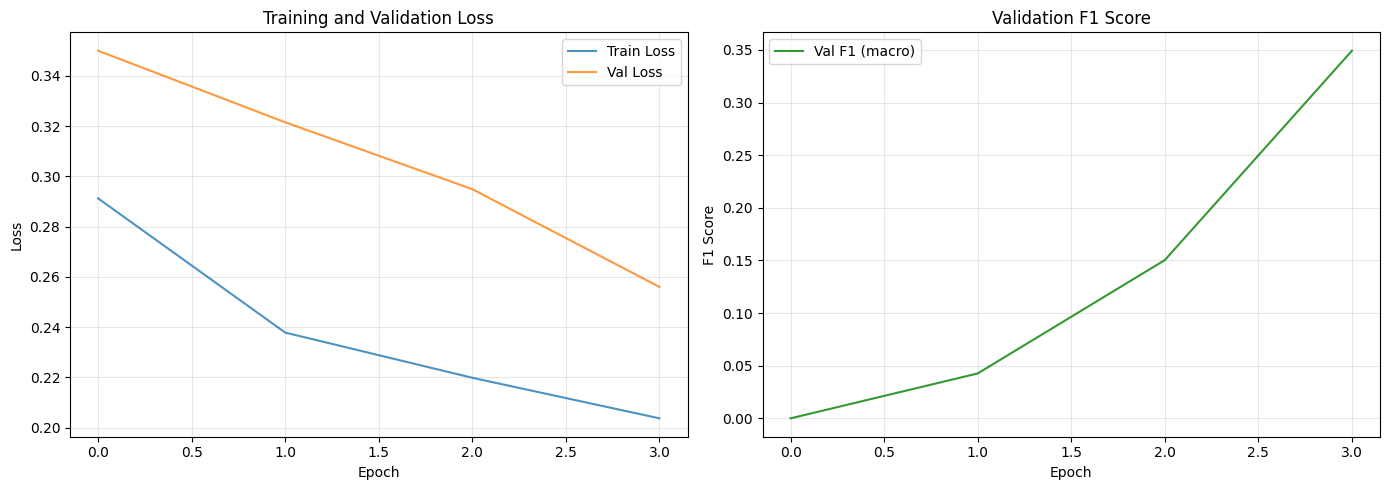

✓ Plot saved!


In [15]:
# 📊 Training Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', alpha=0.8)
axes[0].plot(history['val_loss'], label='Val Loss', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_f1'], label='Val F1 (macro)', color='green', alpha=0.8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=150)
plt.show()
print("✓ Plot saved!")

In [16]:
# 💾 Save Complete Checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': {
        'BERT_MODEL': BERT_MODEL,
        'DECODER_DIM': DECODER_DIM,
        'DEPTH': DEPTH,
        'HEADS': HEADS,
        'MAX_LEN': MAX_LEN,
        'THRESHOLD': THRESHOLD,
        'FREEZE_BERT': FREEZE_BERT,
        'num_labels': len(label_cols)
    },
    'label_cols': label_cols,
    'best_val_f1': best_val_f1,
    'test_f1_macro': test_f1_macro,
    'test_f1_micro': test_f1_micro,
    'history': history
}

torch.save(checkpoint, '/kaggle/working/bert_transformer_complete.pth')

print(f"\n{'='*60}")
print("💾 Model Saved")
print(f"{'='*60}")
print(f"Best Val F1: {best_val_f1:.4f}")
print(f"Test F1 (macro): {test_f1_macro:.4f}")
print(f"Test F1 (micro): {test_f1_micro:.4f}")

print("\nOutput Files:")
for f in os.listdir('/kaggle/working/'):
    size = os.path.getsize(os.path.join('/kaggle/working/', f)) / 1e6
    print(f"  {f} ({size:.2f} MB)")


💾 Model Saved
Best Val F1: 0.3493
Test F1 (macro): 0.3493
Test F1 (micro): 0.5218

Output Files:
  .virtual_documents (0.00 MB)
  training_history.png (0.10 MB)
  best_bert_transformer_model.pth (1134.81 MB)
  bert_transformer_complete.pth (1134.81 MB)
